In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, average_precision_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score
from tqdm.auto import tqdm

from graph import _get_genes, _get_phenotypes, _get_positive_negative_edges, _load_gen_df, _load_phn_df, _merge_dfs

In [2]:
df = pd.read_csv('results.csv')
df

,Gen,Phn,p
0,ERCC1,D1071,0.881632
1,DDX54,D1071,0.845112
2,SNCAIP,D1071,0.698243
3,DNMT3A,D1071,0.833472
4,PAICS,D1071,0.470386
...,...,...,...
899635,GKN1,D1222,0.000014
899636,ITPKB,D1222,0.000014
899637,Mar-05,D1222,0.000014
899638,MORF4,D1222,0.000000


In [3]:
df_gen = _load_gen_df()
df_phn = _load_phn_df()

genes = _get_genes(df_gen, df_phn)
phenotypes = _get_phenotypes(df_phn)

positive_edges, _ = _get_positive_negative_edges(_merge_dfs(df_gen, df_phn), genes, phenotypes)
positive_edges = pd.DataFrame({'Gen': positive_edges['Nod_B'], 'Phn': positive_edges['Nod_A'], 'GT': 1})
positive_edges

,Gen,Phn,GT
0,MAP3K4-AS1,D1071,1
1,MAP3K4,D1071,1
2,CDKN2B-AS1,D1071,1
3,NAA25,D1071,1
4,RPS16P9,D1071,1
...,...,...,...
875436,NCKAP1,D1095,1
891468,PPP1R13B,D1222,1
899277,ATP5MJ,D1222,1
899278,TDRD9,D1222,1


In [4]:
df = pd.merge(df, positive_edges, on=['Gen', 'Phn'], how='left').fillna(0)
df['GT'] = df['GT'].astype(int)
df

,Gen,Phn,p,GT
0,ERCC1,D1071,0.881632,1
1,DDX54,D1071,0.845112,1
2,SNCAIP,D1071,0.698243,1
3,DNMT3A,D1071,0.833472,1
4,PAICS,D1071,0.470386,1
...,...,...,...,...
899635,GKN1,D1222,0.000014,0
899636,ITPKB,D1222,0.000014,0
899637,Mar-05,D1222,0.000014,0
899638,MORF4,D1222,0.000000,0


Plot probability distribution returned by the model:

<AxesSubplot:>

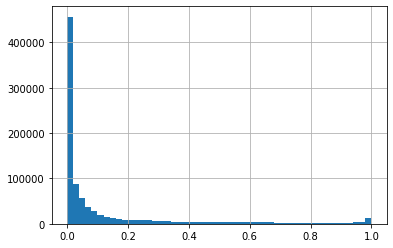

In [5]:
df['p'].hist(bins=50)

Compute performance metrics across all cross-validation folds:

In [6]:
y_test = df['GT'].values
y_prob = df['p'].values
y_pred = (y_prob > 0.5).astype(int)

{
    'Acc': np.round(accuracy_score(y_test, y_pred), 4),
    'BAC': np.round(balanced_accuracy_score(y_test, y_pred), 4),
    'Precision': np.round(precision_score(y_test, y_pred), 4),
    'Recall': np.round(recall_score(y_test, y_pred), 4),
    'PR-AUC': np.round(average_precision_score(y_test, y_prob), 4),
    'AUC': np.round(roc_auc_score(y_test, y_prob), 4),
}

{'Acc': 0.9138,
 'BAC': 0.8774,
 'Precision': 0.1,
 'Recall': 0.8402,
 'PR-AUC': 0.4269,
 'AUC': 0.9484}

Plot confusion matrix, with probability threshold for link prediction = 0.5:

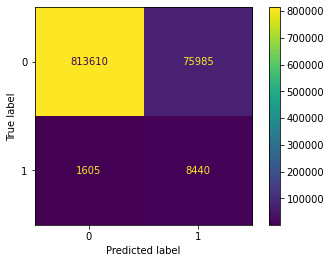

In [7]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Plot confusion matrix, with probability threshold for link prediction = 0.9:

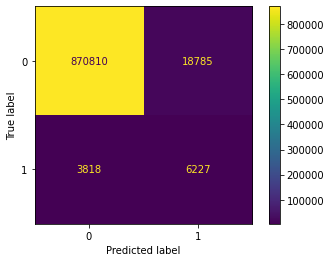

In [8]:
cm = confusion_matrix(y_test, (y_prob > 0.9).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Split dataframe into known (`df_o`) and unknown (`df_n`) links:

In [9]:
df_o = df[df['GT'] == 1].copy()
df_o

,Gen,Phn,p,GT
0,ERCC1,D1071,0.881632,1
1,DDX54,D1071,0.845112,1
2,SNCAIP,D1071,0.698243,1
3,DNMT3A,D1071,0.833472,1
4,PAICS,D1071,0.470386,1
...,...,...,...,...
721716,PYGO2,D1094,0.040210,1
721717,TMOD1,D1094,0.024044,1
721718,HAUS4P1,D1094,0.458876,1
721719,TSTD2,D1094,0.458876,1


For unknown links also compute the hits at both thresholds (0.5 and 0.9):

In [10]:
df_n = df[df['GT'] == 0].copy()
df_n['h.5'] = (df_n['p'] > 0.5).astype(int)
df_n['h.9'] = (df_n['p'] > 0.9).astype(int)
df_n

,Gen,Phn,p,GT,h.5,h.9
2009,CBL,D1071,0.985390,0,1,1
2010,MC2R,D1071,0.831076,0,1,0
2011,APP,D1071,0.991663,0,1,1
2012,AKAP8,D1071,0.664785,0,1,0
2013,PLCG1,D1071,0.901406,0,1,1
...,...,...,...,...,...,...
899635,GKN1,D1222,0.000014,0,0,0
899636,ITPKB,D1222,0.000014,0,0,0
899637,Mar-05,D1222,0.000014,0,0,0
899638,MORF4,D1222,0.000000,0,0,0


Count the number of known links per phenotype:

In [11]:
df_o['Phn'].value_counts()

D1071    1105
D1251    1022
D1249    1003
D1075     752
D1536     494
         ... 
D1312       3
D1074       3
D1280       1
D1095       1
D1154       1
Name: Phn, Length: 72, dtype: int64

Count the number of predicted unknown links per phenotype:

In [12]:
df_n.groupby('Phn')[['h.5', 'h.9']].agg('sum').reset_index()

,Phn,h.5,h.9
0,C1007,259,38
1,C1010,579,264
2,C1052,568,151
3,C1067,527,228
4,C1068,523,263
...,...,...,...
67,L2003,458,48
68,L2004,482,121
69,L2005,689,215
70,L2006,440,98


In [13]:
counts = df_n.groupby('Phn')[['h.5', 'h.9']].agg('sum')
counts = counts.merge(df_o['Phn'].value_counts().to_frame(), left_index=True, right_index=True)
counts = counts.rename(columns={'Phn': '# of known edges'})
counts = counts[['# of known edges', 'h.5', 'h.9']]
counts = counts.sort_values('# of known edges', ascending=False)

print(counts.to_string())

        # of known edges   h.5   h.9
D1071               1105  8500  1239
D1251               1022  3150   846
D1249               1003  2740   810
D1075                752  1515   682
D1536                494  2675   839
D1250                482  1256   597
D1416                396  1171   566
D1245                372  1667   709
D1153                369  1143   553
ModDRm               334  8282  1084
HumAge               307  6319   541
D1524                295  1204   530
HumCel               279  7664   845
D1155                263  1155   508
D1284                259  1155   517
D1526                221  2233   666
D1269                157  1231   547
C1010                153   579   264
C1068                115   523   263
D1523                111   969   340
C1069                110   515   242
D1085                 87   335   130
D1112                 79   320   132
C1067                 68   527   228
D1182                 66   932   442
D1183                 63   894   392
D

Create dataframe containing probability matrix of predicted link probability between genes and phenotypes:

In [14]:
rows = []

for gene in tqdm(genes):
    row = []
    
    ds = df[df['Gen'] == gene]
    
    for phenotype in phenotypes:
        dx = ds[ds['Phn'] == phenotype]
        
        assert len(dx) == 1
        
        if dx['GT'].iloc[0] == 1:
            row.append(np.nan)
        else:
            row.append(dx['p'].iloc[0])
    
    rows.append(row)

dm = pd.DataFrame(rows, columns=phenotypes)
dm

  0%|          | 0/12495 [00:00<?, ?it/s]

,D1071,HumCel,D1536,D1251,D1249,D1526,ModDRm,D1091,D1092,D1082,...,D1351,D1595,D1154,D1218,D1304,D1094,D1280,D1518,D1095,D1222
0,NaN,0.084926,NaN,1.000000,0.991551,0.983939,0.097323,NaN,NaN,NaN,...,0.976942,0.995270,0.000000,0.000468,0.000000,0.363555,0.037147,0.364886,0.005025,0.057425
1,NaN,0.272699,NaN,1.000000,0.999984,0.999485,0.461410,NaN,NaN,NaN,...,0.890999,0.657835,0.075377,0.002373,0.000000,0.549174,0.000000,0.046625,0.031521,0.038881
2,NaN,0.128103,0.999906,1.000000,0.996791,0.994368,0.147075,NaN,NaN,NaN,...,0.993397,0.996560,0.035957,0.463240,0.000000,0.996512,0.000000,0.967670,0.020362,0.003896
3,NaN,0.649112,0.999433,NaN,NaN,0.999784,0.330742,0.976026,0.995659,0.911442,...,0.944391,0.940217,0.077276,0.012975,0.000299,0.988077,0.017823,0.960998,0.009727,0.004267
4,NaN,0.208866,NaN,0.988128,0.989390,0.579879,0.107458,0.916512,0.949929,0.930678,...,0.911658,0.778618,0.000000,0.001504,0.005244,0.146853,0.026614,0.013097,0.001423,0.002240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12490,0.886038,NaN,0.190372,0.622819,0.590830,0.545953,0.882943,0.066413,0.000294,0.020847,...,0.000000,0.000000,0.000165,0.054609,0.000111,0.275562,0.028180,0.081762,0.040584,0.036022
12491,0.651294,NaN,0.653853,0.362789,0.546040,0.377965,0.885956,0.007089,0.041540,0.016623,...,0.000778,0.000685,0.000000,0.021350,0.004924,0.125732,0.001771,0.061946,0.062186,0.000000
12492,0.886038,NaN,0.329624,0.480238,0.590830,0.531873,0.872233,0.102162,0.016991,0.016623,...,0.002339,0.000000,0.000000,0.041998,0.000111,0.275562,0.028180,0.061946,0.000000,0.000000
12493,0.886038,NaN,0.397645,0.552271,0.470242,0.531873,0.723885,0.007089,0.041540,0.020847,...,0.022473,0.000000,0.000165,0.057871,0.000111,0.000210,0.000000,0.029138,0.082531,0.001125


Add information about the sum of predicted probabilities for each gene:

In [15]:
dm.index = genes
dm['Total'] = dm[phenotypes].sum(axis=1)
dm = dm.sort_values('Total', ascending=False)
dm

,D1071,HumCel,D1536,D1251,D1249,D1526,ModDRm,D1091,D1092,D1082,...,D1595,D1154,D1218,D1304,D1094,D1280,D1518,D1095,D1222,Total
L2007,0.553999,0.012609,0.996135,0.999997,1.000000,0.036703,0.000534,0.999908,0.999736,0.999560,...,0.996244,0.010370,0.885740,0.620995,0.152749,0.000000,0.045367,0.004612,0.000000,49.392885
CTSH,0.999197,0.360692,0.871493,0.932526,0.937276,0.974683,0.277755,NaN,0.972682,0.974553,...,0.907098,0.047002,0.005385,0.255643,0.973214,0.000000,0.524568,0.001260,0.000000,45.728298
RPL21P116,0.845931,0.038278,0.992880,0.831462,0.999996,0.587824,0.150658,0.996436,0.970399,0.956606,...,0.804463,0.000000,0.005547,0.000000,0.125999,0.000407,0.065366,0.007301,0.000000,45.276862
RNU6-415P,0.997573,0.038314,0.950375,0.994024,0.981224,0.919195,0.157384,0.991602,0.970399,0.956606,...,0.879872,0.000000,0.000068,0.000485,0.647263,0.000000,0.649580,0.003128,0.000000,43.800501
ADAMTS7,0.990901,0.252417,0.973398,0.999102,0.971929,0.548587,0.110439,0.963503,0.987141,0.990332,...,0.877418,0.000000,0.000000,0.000484,0.125235,0.000000,0.983201,0.007832,0.075051,43.468813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAF4B,0.354491,0.486492,0.221943,0.143319,0.128890,0.123558,0.439284,0.000000,0.000121,0.000000,...,0.000764,0.007383,0.000000,0.012269,0.089401,0.000000,0.011870,0.059411,0.000007,3.026677
NPM2,0.370973,0.402557,0.260425,0.160067,0.239726,0.134993,0.392581,0.000000,0.000147,0.000131,...,0.003859,0.000076,0.002420,0.069149,0.000188,0.000000,0.007044,0.000000,0.001506,3.021982
GCLM,0.474235,0.706355,0.163194,0.196050,0.177093,0.186171,NaN,0.002956,0.002235,0.000000,...,0.000355,0.000000,0.014778,0.014344,0.013987,0.000000,0.031171,0.000000,0.000000,2.994617
RN7SL634P,0.733837,0.161804,0.000000,0.552271,0.000077,0.194177,0.184054,0.000000,0.009080,0.008188,...,0.007937,0.000658,0.006041,0.002370,0.000000,0.000000,0.000000,0.000000,NaN,2.488074


Show the sum of predicted probabilities for each phenotype:

In [16]:
print(dm[phenotypes].sum(axis=0).to_string())

D1071     7187.572711
HumCel    7086.538005
D1536     4742.844785
D1251     4888.808357
D1249     4607.225624
D1526     4205.680090
ModDRm    7306.781669
D1091     1098.323926
D1092     1089.859253
D1082     1077.999277
L2001     1228.904671
L2005      928.038205
D1112     1086.590134
D1111      773.497486
D1502      473.159197
D1085     1129.480599
D1245     2824.960743
D1075     2465.514496
D1183     1634.785109
D1182     1746.972483
D1156     1192.774949
D1248      470.230095
C1007     1404.217312
D1525     1012.537121
HumAge    6428.892087
D1077      697.454760
D1321      907.179197
C1010     1299.715547
C1068     1000.376809
C1069      936.572332
D1250     1490.277148
D1416     1450.555343
D1153     1407.476493
D1524     1393.059290
D1269     1498.285666
D1284     1358.024063
D1523     1136.335203
D1537     1014.651476
D1320      796.800575
D1155     1343.875154
L2003      678.529373
D1159      887.463201
D1268      651.531678
C1080      346.734411
D1073      612.263179
D1076     

Calculate the number of known links for each gene, and compare that with the sum of predicted probabilities of novel ones:

In [17]:
dm['Known'] = dm.isna().sum(axis=1)

In [18]:
print(dm[['Total', 'Known']].iloc[:100].to_string())

                  Total  Known
L2007         49.392885      0
CTSH          45.728298      6
RPL21P116     45.276862      5
RNU6-415P     43.800501      5
ADAMTS7       43.468813      5
MIR6088       42.988681     12
TTC6          42.190974      2
NAA25         41.301752     10
CPED1         41.159482      2
SPG7          41.037755      5
CHRNB4        40.915656      4
LINC00567     40.644866      3
TAF9BP2       40.356596      5
SPIRE2        40.344614      5
MAP3K4-AS1    40.211526     11
DDX43P2       40.205763      1
PRKN          40.202306      7
RPS16P9       40.130800      5
RPS2P41       40.083054     11
GLUD1P3       39.896130      3
C11orf24      39.841232      2
NDUFA5P10     39.791048      7
DAZAP2P1      39.774732      4
FAM13A        39.643566      5
DUSP8P5       39.549021      3
PPP1R13L      39.415881     12
POLR1G        39.268645     12
CHCHD1        38.628603      3
CDKN2B-AS1    38.566959     15
BPIFB3        38.420814      4
THADA         38.381118      7
AGPAT4  

Plot the histogram of sums of predicted probabilities for all genes:

<AxesSubplot:>

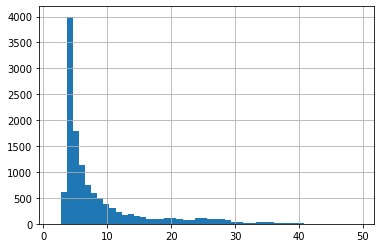

In [19]:
dm['Total'].hist(bins=50)